In [1]:
# General libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", None)

import os
import random
import re
import gc

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# HuggingFace
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict


In [2]:
train_data=pd.read_csv(r'D:\BaiduNetdiskDownload\python\项目\文本处理项目\nlp-getting-started\train.csv')
test_data=pd.read_csv(r'D:\BaiduNetdiskDownload\python\项目\文本处理项目\nlp-getting-started\test.csv')
train_data.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
#整个文档是否有重复值
train_data.duplicated().sum()

0

In [5]:
#重要特征是否有重复值
train_data.duplicated(subset='text').sum()

110

In [6]:
#重要特征和标签是否有重复值
train_data.duplicated(subset=['text','target']).sum()

92

In [7]:
#删除重复值
train_data.drop_duplicates(subset=['text','target'],inplace=True)

<AxesSubplot:xlabel='target', ylabel='count'>

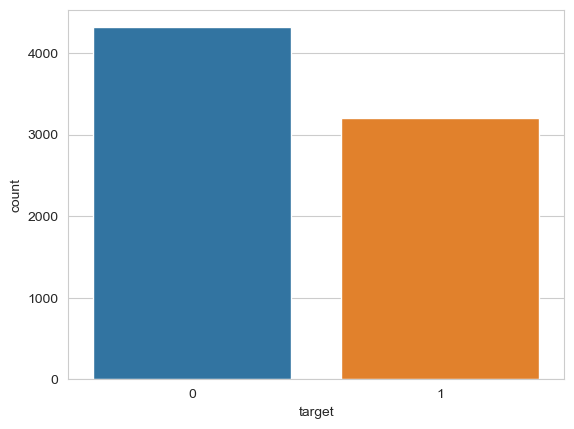

In [8]:
#查看标签分布
# sns.histplot(train_data['target'],)
sns.countplot(train_data,x='target')

<AxesSubplot:>

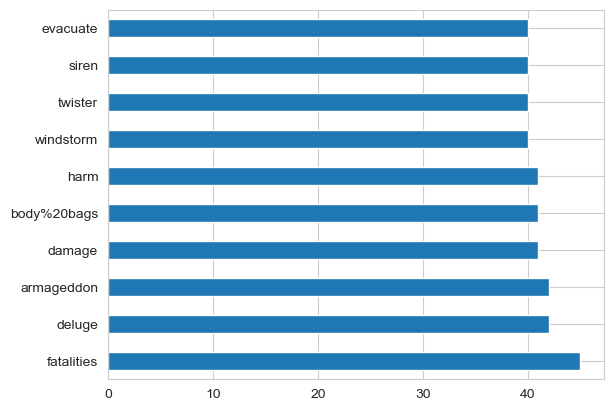

In [9]:
#查看辅助字段和标签之间的关系
train_data['keyword'].value_counts().head(10).plot(kind='barh')


<AxesSubplot:ylabel='keyword'>

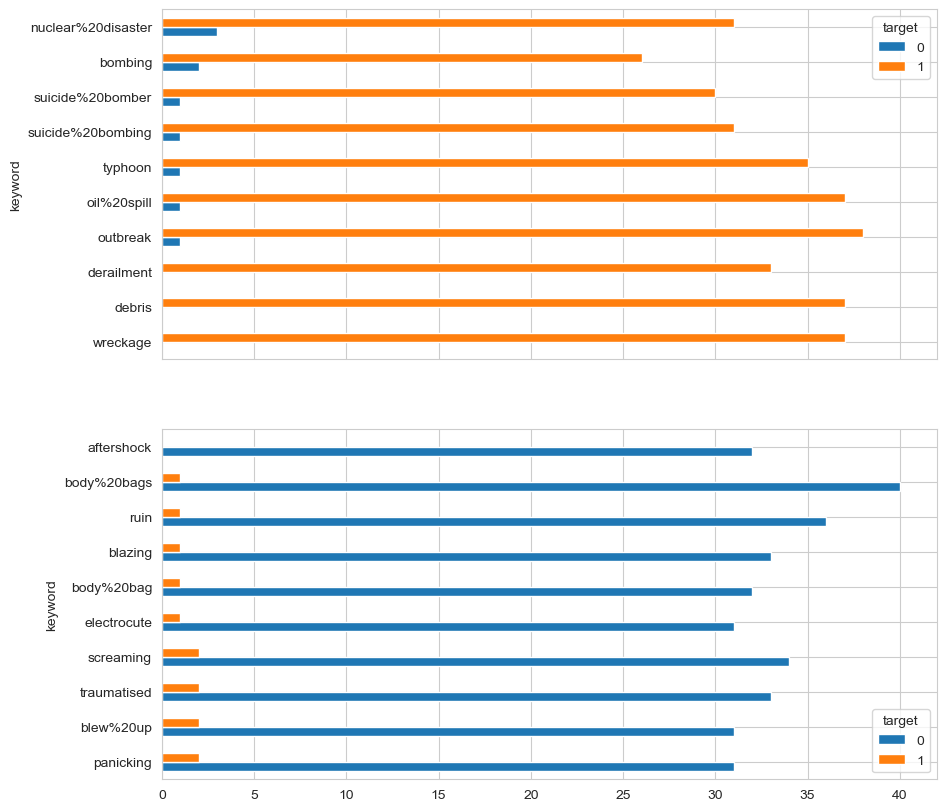

In [10]:
keyword_target=train_data.groupby(['keyword','target']).size().unstack(fill_value=0)
keyword_target['disaster_ratio']=keyword_target[1]/(keyword_target[0]+keyword_target[1])
keyword_target.sort_values(by='disaster_ratio',ascending=False,inplace=True)
fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(10,10),sharex=True)
keyword_target.head(10)[[0,1]].plot(kind='barh',ax=axs[0])
keyword_target.tail(10)[[0,1]].plot(kind='barh',ax=axs[1])

In [11]:
#对无关键字填值
train_data['keyword'].fillna('nokeyword',inplace=True)
test_data['keyword'].fillna('nokeyword',inplace=True)

<AxesSubplot:>

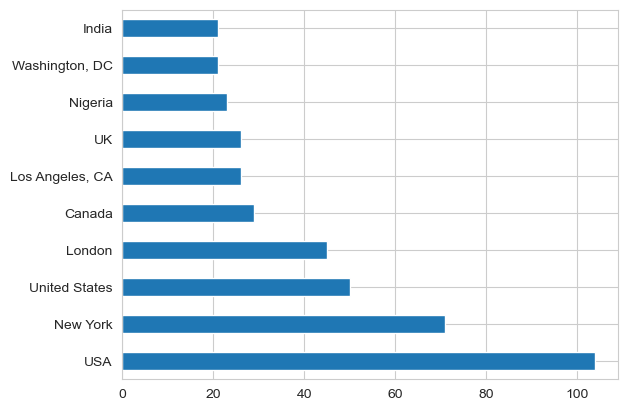

In [12]:
#分析location
train_data['location'].value_counts().head(10).plot(kind='barh')

In [13]:
location_target=train_data.groupby(['location','target']).size().unstack(fill_value=0)
location_target['disaster_ratio']=location_target[1]/(location_target[0]+location_target[1])
location_target.sort_values(by='disaster_ratio',ascending=False,inplace=True)
location_target

target,0,1,disaster_ratio
location,,,
,0,1,1.000000
"Melbourne, Florida",0,1,1.000000
Milton/Tallahassee,0,1,1.000000
Midwestern USA,0,1,1.000000
Midwest,0,4,1.000000
Middle Earth / Asgard / Berk,0,1,1.000000
Mid north coast of NSW,0,1,1.000000
"Miami,Fla",0,1,1.000000
"Miami,FL",0,1,1.000000


<AxesSubplot:ylabel='location'>

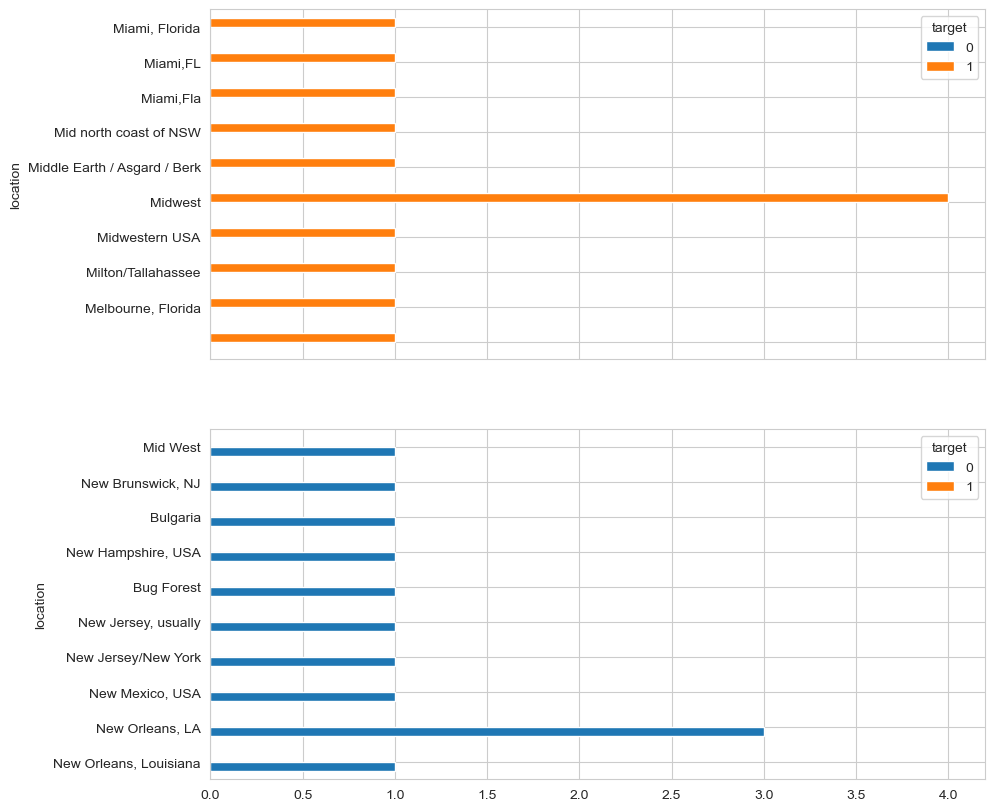

In [14]:
fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(10,10),sharex=True)
location_target.head(10)[[0,1]].plot(kind='barh',ax=axs[0])
location_target.tail(10)[[0,1]].plot(kind='barh',ax=axs[1])

In [15]:
train_data['location'].fillna('nolocation',inplace=True)
test_data['location'].fillna('nolocation',inplace=True)

In [16]:
#组合输入文本字段
train_data['input']='keyword:'+train_data['keyword']+ 'location:'+train_data['location']+'text:'+train_data['text']

In [17]:
test_data['input']='keyword:'+test_data['keyword']+ 'location:'+test_data['location']+'text:'+test_data['text']

In [18]:
train_data.head(5)

,id,keyword,location,text,target,input
0,1,nokeyword,nolocation,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,keyword:nokeywordlocation:nolocationtext:Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,4,nokeyword,nolocation,Forest fire near La Ronge Sask. Canada,1,keyword:nokeywordlocation:nolocationtext:Forest fire near La Ronge Sask. Canada
2,5,nokeyword,nolocation,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,keyword:nokeywordlocation:nolocationtext:All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,6,nokeyword,nolocation,"13,000 people receive #wildfires evacuation orders in California",1,"keyword:nokeywordlocation:nolocationtext:13,000 people receive #wildfires evacuation orders in California"
4,7,nokeyword,nolocation,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,keyword:nokeywordlocation:nolocationtext:Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


In [19]:
#查看文本长度
train_data['input_length']=train_data['input'].apply(len)
train_data['input_length'].describe(percentiles=[0,0.25,0.5,0.75,0.99]).round(0)

count    7521.0
mean      144.0
std        35.0
min        44.0
0%         44.0
25%       119.0
50%       150.0
75%       175.0
99%       199.0
max       215.0
Name: input_length, dtype: float64

<AxesSubplot:xlabel='input_length', ylabel='Count'>

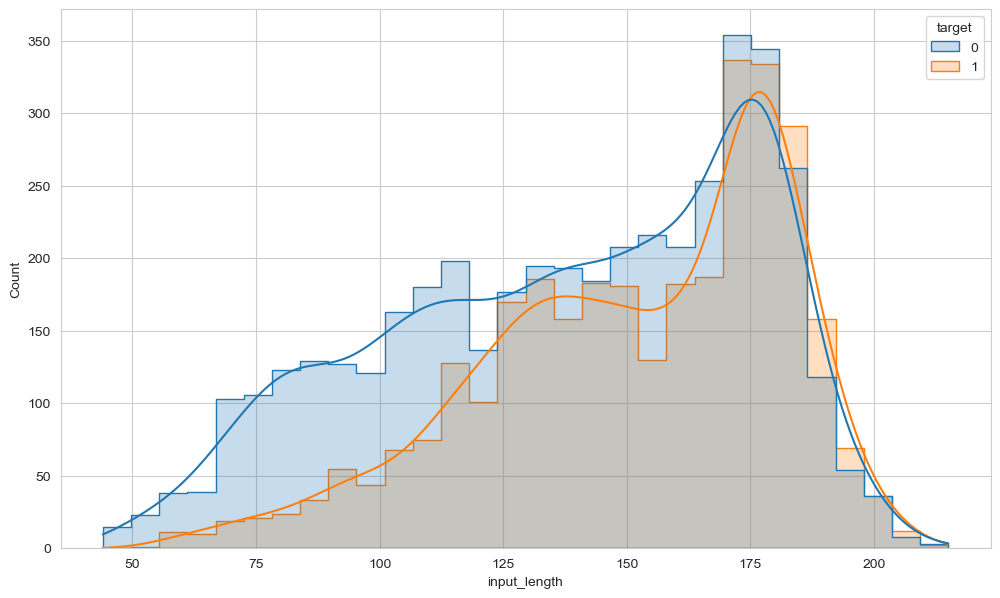

In [20]:
#这是什么图？参考意义，画图各关键参数hue:颜色
plt.figure(figsize=(12,7))
sns.histplot(data=train_data,x='input_length',hue='target',kde=True,element='step')

In [34]:
train_data['target']=train_data['target'].astype('float32')

In [35]:
from transformers import AutoTokenizer
model_name='microsoft/deberta-v3-small'
tokenizer=AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
D:\Users\13404\anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [36]:
def tokenize_text(x):
    return tokenizer(x['input'],padding='max_length',truncation=True,max_length=199)

In [37]:
train_ds=Dataset.from_pandas(train_data[['id','target','input']])
train_ds=train_ds.rename_columns({'target':'labels'})
train_ds

Dataset({
    features: ['id', 'labels', 'input', '__index_level_0__'],
    num_rows: 7521
})

In [38]:
test_ds=Dataset.from_pandas(test_data[['id','input']])
test_ds

Dataset({
    features: ['id', 'input'],
    num_rows: 3263
})

In [39]:
train_ds_tokens=train_ds.map(tokenize_text,batched=True)
train_ds_tokens

Map:   0%|          | 0/7521 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'labels', 'input', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7521
})

In [40]:
test_ds_tokens=test_ds.map(tokenize_text,batched=True)
test_ds_tokens

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3263
})

In [41]:
#分割训练集和测试集
train_dds=train_ds_tokens.train_test_split(0.2,seed=42)
train_dds

DatasetDict({
    train: Dataset({
        features: ['id', 'labels', 'input', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6016
    })
    test: Dataset({
        features: ['id', 'labels', 'input', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1505
    })
})

In [42]:
#构建模型
bs=32
epochs=4
lr=8e-5
#构建模型参数
args=TrainingArguments(output_dir='outputs'
                       ,learning_rate=lr
                       ,warmup_ratio=0.1
                       ,lr_scheduler_type='cosine'
                       # ,fp16=True
                       ,evaluation_strategy='epoch'
                       ,per_device_train_batch_size=bs
                       ,per_device_eval_batch_size=bs*2
                       ,num_train_epochs=epochs
                       ,weight_decay=0.01
                       ,report_to='none')
#构建模型
model=AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=1,ignore_mismatched_sizes=True)


Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [43]:
gc.collect()
torch.cuda.empty_cache()


In [ ]:
trainer=Trainer(model,args,train_dataset=train_dds['train'],eval_dataset=train_dds['test'],tokenizer=tokenizer)
trainer.train()

D:\Users\13404\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
